# Homework 04

## Due Tuesday, March 1st

For all of the plots, make sure that you use labels with units as appropriate, and make good choices about all of the plot characteristics like fontsize, colors, and markersize. Choose colormaps that are appropriate for your data; that is, sequential for sequential data or diverging for diverging data. Don't use the default jet (rainbow) colormap!

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### 1. Basic Line Plotting

Reproduce this image, showing river flow during flood years of the Merrimack River

![Merrimack River Discharge](merrimack_discharge.png)

The data used to create this plot can be found [un t](../data/merrimack_discharge.dat). You may read in the data any way you want. That is, you may extract the data for the years in question by hand, however part of your grade will be based on creating a flexible script that could read in values from another datafile, e.g., from another river gauge. Pay attention to detail.

   - *Undergraduates*: Focus only on the four lines representing river flow in the four specific years (1936, 1938, 1960, 1987).
   - *Graduates*: Do the undergrad work, and then add the black line representing the mean discharge (calculated from the data in the file), and the shaded region representing one standard deviation from the mean.

In [6]:
from datetime import date
import glob

class DailyDischarge(object):
    
    def __init__(self, longname, year, month, day, flow):
        self.longname = longname
        self.year = year
        self.month = month
        self.day = day
        self.flow = flow
    
    def dates(self, other):
        'Returns a list of datetime objects for a specific year.'
        datelist = []
        for i in range(len(self.year)):
            if self.year[i] == other:
                datelist.append(date(self.year[i], self.month[i], self.day[i]))
        return datelist
    
    def flows(self, other):
        'Returns a list of daily mean steamflow for a specific year.'
        flowlist = []
        for i in range(len(self.year)):
            if self.year[i] == other:
                flowlist.append(self.flow[i])
        return flowlist
    
    def masks(self, other=None):
        'Returns an masked array of (number of years)x(daily mean steamflow) or for a specific year.'
        nyear = max(self.year) - min(self.year) + 1
        count = []
        for i in range(nyear):
            count.append(self.year.count(i + min(self.year)))
        res = np.nan*np.ones((nyear, max(count)))
        for i in range(nyear): # This `for` loop can be shortened but then it would take much longer time to calculate.
            if count[i] == max(count):
                res[i, :] = np.array(self.flows(i + min(self.year)))
            elif count[i] == max(count) - 1:
                res[i, :] = np.insert(np.array(self.flows(i + min(self.year))), \
                                       (date(i + min(self.year), 3, min(self.day)) - \
                                        date(i + min(self.year), min(self.month), min(self.day))).days, np.nan)
            else:
                yrarr = np.arange(date(i + min(self.year), min(self.month), min(self.day)), \
                                  date(i + min(self.year) + 1, min(self.month), min(self.day)))
                idx = (yrarr >= min(self.dates(i + min(self.year)))) &  (yrarr <= max(self.dates(i + min(self.year))))
                if yrarr.size != max(count):
                    idx = np.insert(idx, (date(i + min(self.year), 3, min(self.day)) - \
                              date(i + min(self.year), min(self.month), min(self.day))).days, False)
                k = 0
                for j in range(max(count)):
                    if idx[j] & (k < count[i]):
                        res[i, j] = np.array(self.flows(i + min(self.year)))[k]
                        k += 1
        res = np.ma.masked_where(np.isnan(res), res)
        if other:
            return res[other - min(self.year), :]
        else:
            return res
    
discharge = dict()

for pathname in glob.glob('../data/*discharge.dat'):
    f = open(pathname, 'r')
    f.seek(0)
    
    for line in f.readlines():
        if len(list(line)) == 2: continue
        if list(line)[0] == '#':
            if line.split()[1][:2].isupper():
                siteno = line.split()[2]
                longname = ' '.join(line.split()[3:])
                year = []
                month = []
                day = []
                flow = []
                temporary = []
        elif line.split('\t')[1] == siteno:
            data = line.split('\t')
            year.append(int(data[2].split('-')[0]))
            month.append(int(data[2].split('-')[1]))
            day.append(int(data[2].split('-')[2]))
            flow.append(float(data[3])*0.3048**3) # Returns daily mean streamflow value, in cubic-m per-second.
        else:
            continue
    temporary.append(DailyDischarge(longname, year, month, day, flow))
    discharge[siteno] = temporary[0]


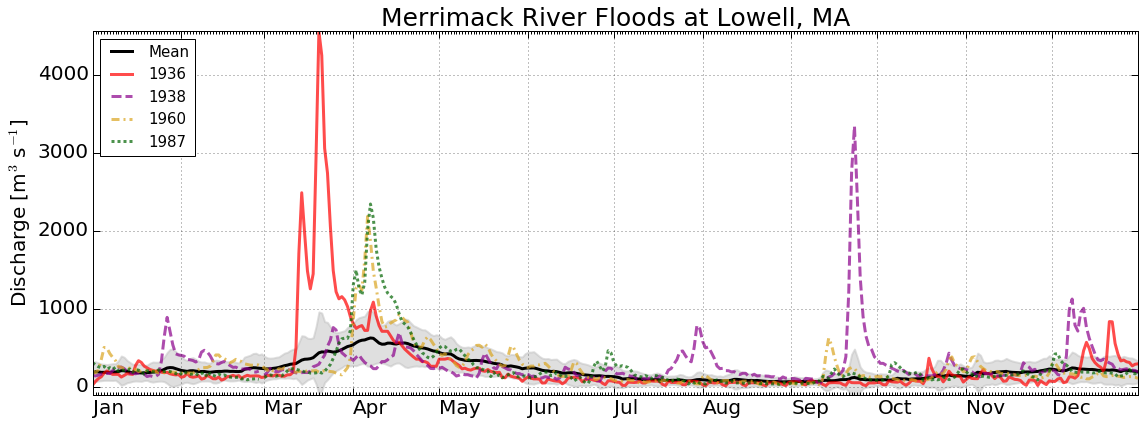

In [7]:
import matplotlib.dates

siteno = '01100000'
years = ['1936', '1938', '1960', '1987']
colors = ['red', 'darkmagenta', 'goldenrod', 'darkgreen']
# linestyles = ['-', '--', '-.', ':']
linestyles = ['', [10, 4], [8, 4, 2, 4], [3, 3]]
x = discharge[siteno].dates(1936)

mu = discharge[siteno].masks().mean(axis=0)
sigma = discharge[siteno].masks().std(axis=0)

fig, ax = plt.subplots(1, figsize=(16, 6))
ax.fill_between(x, mu+sigma, mu-sigma, facecolor='silver', edgecolor='silver', linewidth=2, alpha=0.5)
ax.plot(x, mu, 'k-', linewidth=3, label='Mean')

ymax = []
for n in range(len(years)):
    y = discharge[siteno].masks(int(years[n]))
    ax.plot(x, y, color=colors[n], linestyle='-', linewidth=3, label=years[n], alpha=0.7, dashes=linestyles[n])
    ymax.append(y.max())

for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_xticks(x, minor = True)
ax.tick_params('both', length=7, width=1, which='major', labelsize=20)
ax.grid(True, color='k', linestyle=':', linewidth=0.5)
ax.set_ylim(-100, max(ymax))
ax.set_ylabel('Discharge [m$^{3}$ s$^{-1}$]', fontsize=20)

ax.legend(loc='upper left', handlelength=2, fontsize=15)
ax.set_title('Merrimack River Floods at Lowell, MA', fontsize=25)
fig.tight_layout()

### 2. Plot 2D function multiple ways

Use this code to define a set of gridded data, defined between -3 and 3 in both x and y.

    X, Y = np.meshgrid(np.linspace(-4.2, 6.2, 101), np.linspace(-3.2, 3.2, 101))
    Z = np.cos(X**2+Y**2)*(X**2+Y**2)**-0.25 + 0.2*X*Y*np.sin(Y) \
       + 0.01*X*Y**4*np.sin(X) + 0.2*np.exp(-Y**2)

Create three different plots of Z over the X-Y plane. Use:
* `pcolor`
* `contourf`
* `contour` (with dashed lines for negative values, solid lines for positive values)

Make sure the aspect ratio is 1.

In [8]:
X, Y = np.meshgrid(np.linspace(-4.2, 6.2, 101), np.linspace(-3.2, 3.2, 101))
Z = np.cos(X**2+Y**2)*(X**2+Y**2)**-0.25 + 0.2*X*Y*np.sin(Y) + 0.01*X*Y**4*np.sin(X) + 0.2*np.exp(-Y**2)

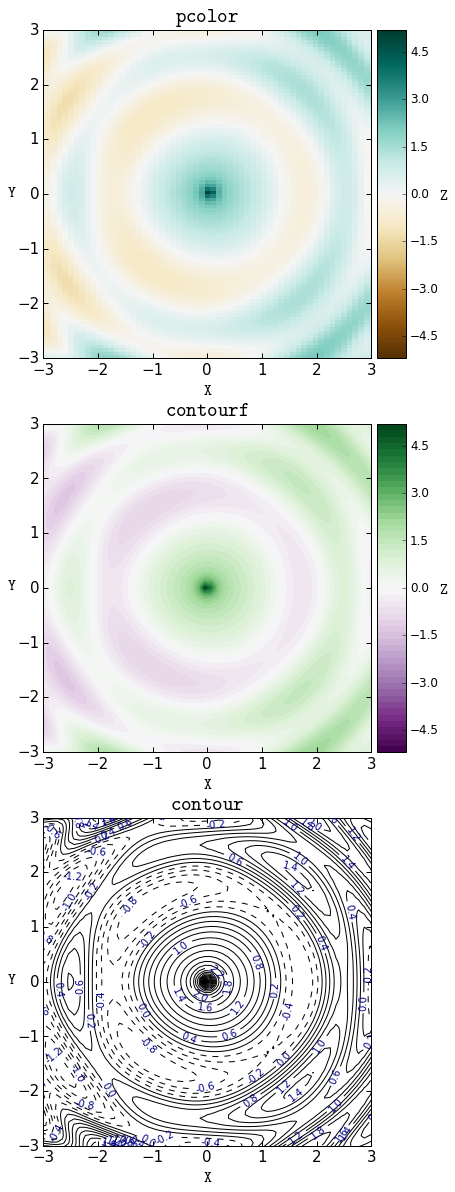

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 20))

Zmax = abs(Z[(X >= -3) & (X <= 3) & (Y >= -3) & (Y <= 3)]).max()
levs = np.linspace(-np.ceil(Zmax*10)*0.1, np.ceil(Zmax*10)*0.1, np.ceil(Zmax*10)+1)

mappable = axes[0].pcolor(X, Y, Z, cmap='BrBG', vmin=-Zmax, vmax=Zmax)
caxes = fig.add_axes([0.705, 0.672, 0.05, 0.228]) 
cbar = plt.colorbar(mappable, ax=axes[0], cax=caxes)
cbar.set_label('$\mathtt{Z}$', y=0.52, fontsize=15, rotation=0)
cbar.ax.tick_params(labelsize=12) 

mappable = axes[1].contourf(X, Y, Z, levs, cmap='PRGn', vmin=-Zmax, vmax=Zmax)
caxes = fig.add_axes([0.705, 0.672-0.2735, 0.05, 0.228]) 
cbar = plt.colorbar(mappable, ax=axes[1], cax=caxes)
cbar.set_label('$\mathtt{Z}$', y=0.52, fontsize=15, rotation=0)
cbar.set_ticks(np.arange(-4.5, 5, 1.5))
cbar.ax.tick_params(labelsize=12) 

CT = axes[2].contour(X, Y, Z, levs, colors='k')
axes[2].clabel(CT, fontsize=10, inline=1, inline_spacing=1, fmt='%.1f', colors='navy')

plots = ['$\mathtt{pcolor}$', '$\mathtt{contourf}$', '$\mathtt{contour}$']
for i, ax in enumerate(axes.flat):
    ax.set_xlabel('$\mathtt{X}$', fontsize=15)
    ax.tick_params('both', length=5, width=1, which='major', labelsize=15)
    ax.axis([-3, 3, -3, 3])
    ax.set_aspect('equal')
    ax.set_ylabel('$\mathtt{Y}$', y=0.485, fontsize=15, rotation=0)
    ax.set_title(plots[i], y=1.01, fontsize=20)
    ax.set_anchor('W')


### 3. Read 2D data and make scatter plot

Temperature and salinity are known to have an important relationship in oceanography. Investigate that relationship in the CTD data from one of the files stored in `data/MCH`. Read in the data and make the following plots as subplots in one figure:

1. plot temperature vs. salinity, using black dots to mark the data points.
1. plot temperature vs. salinity, and color the markers with the depth;
1. plot temperature vs. salinity, color the markers with the depth, and then size the markers with another property of your choice from the file.

Choose a colormap that is different from the default to use for the colors of your markers for the 2nd and 3rd plots.

In [12]:
# This is revised from hw03 and includes transmission (%) as another property chosen.
import glob

class CtdData(object):
    
    def __init__(self, filename, dpth, temp, salt, tran):
        self.filename = filename
        self.dpth = dpth
        self.temp = temp
        self.salt = salt
        self.tran = tran
    
MCH = []

for pathname in glob.glob('../data/MCH/*.cnv2'):
    f = open(pathname, 'r')
    f.seek(0)
    
    filename = '.'.join(pathname.split('/')[-1].split('.')[:-1])
    dpth = []
    temp = []
    salt = []
    tran = []
   
    for line in f.readlines():
        if list(line)[0] == ' ':
            data = line.split()
            dpth.append(float(data[1]))
            temp.append(float(data[2]))
            salt.append(float(data[5]))
            tran.append(float(data[9]))
        else:
            continue
    MCH.append(CtdData(filename, dpth, temp, salt, tran))


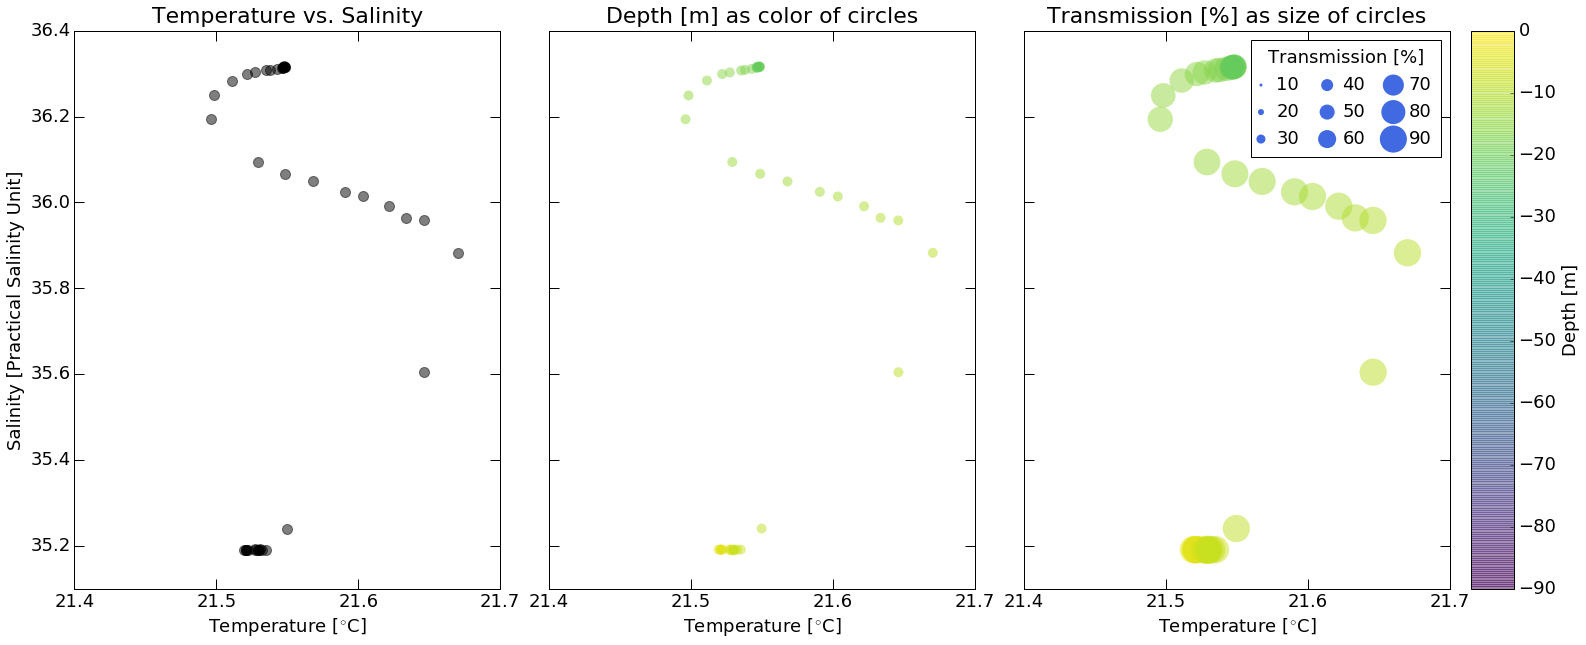

In [13]:
import matplotlib.gridspec as gridspec

mch = -1 # the last file is chosen
trans = np.pi*(np.array(MCH[mch].tran)/min([min(MCH[n].tran) for n in range(len(MCH))]))**2
plots = ['Temperature vs. Salinity', 'Depth [m] as color of circles', 'Transmission [%] as size of circles']

fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(1, 3)
gs.update(left=0, right=0.955, hspace=0, wspace=0.115)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:, 1])
ax3 = plt.subplot(gs[:, 2])
cgs = gridspec.GridSpec(1, 1)
cgs.update(left=0.97, right=1, hspace=0, wspace=0)
caxes = plt.subplot(cgs[:, :])
axes = [ax1, ax2, ax3]

ax1.scatter(MCH[mch].temp, MCH[mch].salt, s=100, color='k', edgecolor='k', alpha=0.5)
ax1.set_ylabel('Salinity [Practical Salinity Unit]', fontsize=18)

mappable = ax2.scatter(MCH[mch].temp, MCH[mch].salt, s=100, c=-np.array(MCH[mch].dpth), cmap='viridis', \
                       edgecolor='none', \
                       vmin=-np.ceil(np.array(max([max(MCH[n].dpth) for n in range(len(MCH))]))*0.1)*10, vmax=0, \
                       alpha=0.5)
cbar = plt.colorbar(mappable, ax=ax3, cax=caxes)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Depth [m]', fontsize=18)
ax2.tick_params('y', labelleft='off')

ax3.scatter(MCH[mch].temp, MCH[mch].salt, s=trans, c=-np.array(MCH[mch].dpth), cmap='viridis', edgecolor='none', \
            vmin=-np.ceil(np.array(max([max(MCH[n].dpth) for n in range(len(MCH))]))*0.1)*10, vmax=0, alpha=0.5)
ax3.tick_params('y', labelleft='off')

for i, ax in enumerate(axes):
    ax.set_xlim(np.floor(np.array(min(MCH[mch].temp))*10)*0.1, np.ceil(np.array(max(MCH[mch].temp))*10)*0.1)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 0.1))
    ax.set_xlabel('Temperature [$^{\circ}$C]', fontsize=18)
    ax.tick_params('both', length=10, width=1, which='major', labelsize=18)
    ax.set_ylim(np.floor(np.array(min(MCH[mch].salt))*10)*0.1, np.ceil(np.array(max(MCH[mch].salt))*10)*0.1)
    ax.set_title(plots[i], y=1.005, fontsize=22)

ll = []
dotsizes = np.arange(1, 10)*10
for i in range(len(dotsizes)):
    ll.append(plt.scatter([],[], s=np.pi*(dotsizes[i]/min([min(MCH[n].tran) for n in range(len(MCH))]))**2, \
                          c='royalblue', edgecolors='none'))
labels = dotsizes.astype(str).tolist()
legend = ax3.legend(ll, labels, title='Transmission [%]', fontsize=18, loc=0, ncol=int(len(labels)/3), \
                    scatterpoints=1, handlelength=.1, labelspacing=.5, columnspacing=1.5, borderpad=.5)
plt.setp(legend.get_title(), fontsize=18)

plt.show()

### 4. Histogram

Make a 1D histogram of wind speed from the BURL1 NOAA weather station. Load the data like this:

    burl = np.genfromtxt('http://www.ndbc.noaa.gov/view_text_file.php?filename=burl1h2010.txt.gz&dir=data/historical/stdmet/')
    wind_speed = burl[:, 6]

*Bonus*: What kind of probability distribution does this look like? Plot your best guess on top of the histogram using a line.

In [14]:
burl = np.genfromtxt('http://www.ndbc.noaa.gov/view_text_file.php?filename=burl1h2010.txt.gz&dir=data/historical/stdmet/')
wind_speed = burl[:, 6]

Distribution   RMS Error  
   normal     58.955321162183864
Student's T   58.99749773964298
    chi       59.02343134080174
     F        59.075593120427826
   gamma      59.087623985696894
  Laplace     59.29902022391854
chi-squared   768370953.7918576


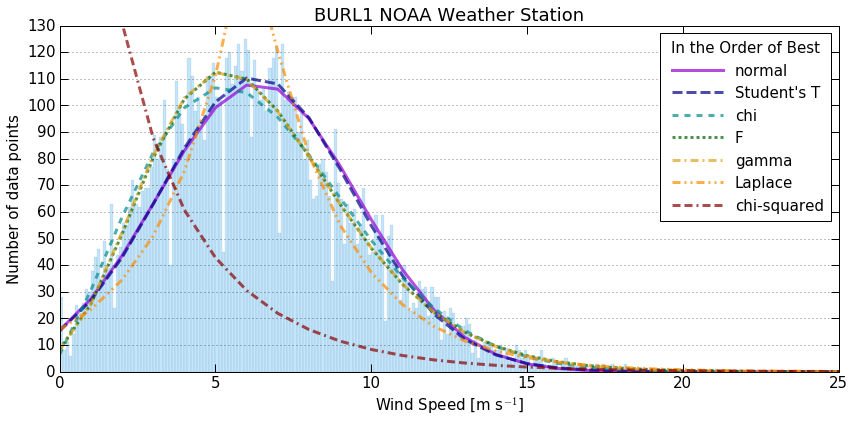

In [15]:
import scipy.stats

const = 10
nbins = np.ceil(wind_speed.max())*const

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
counts, bins, _ = ax.hist(wind_speed, bins=int(nbins), color='lightskyblue', linewidth=0.1, alpha=0.5)
ax.set_xlim(0, np.ceil(wind_speed.max()/5)*5)
ax.set_xlabel('Wind Speed [m s$^{-1}$]', fontsize=15)
ax.tick_params('both', length=8, width=1, which='major', labelsize=15)
ax.set_ylim(0, np.ceil(counts.max()*0.1)*10)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end+1, 10))
ax.yaxis.grid(True, color='k', linestyle=':', linewidth=0.5)
ax.set_ylabel('Number of data points', fontsize=15)
ax.set_title('BURL1 NOAA Weather Station', fontsize=18)

np.seterr(invalid='ignore')
dist_names = ['chi', 'chi2', 'gamma', 'f', 'laplace', 'norm', 't']
long_names = {'chi':'chi', 'chi2':'chi-squared', 'f':'F', 'gamma':'gamma', 'laplace':'Laplace', \
              'norm':'normal', 't':"Student's T"}
x = np.arange(nbins+1)
rmse = np.nan*np.ones(len(dist_names))
for n, dist_name in enumerate(dist_names):
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(wind_speed)
    fitpdf = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])*wind_speed.size/const
    cmavgs =[np.mean(fitpdf[i-1:i+1]) for i in np.arange(1, fitpdf.size)]
    rmse[n] = np.sqrt(np.mean((cmavgs-counts)**2))

dist_bests = [''.join(np.array(dist_names)[rmse == np.sort(rmse)[i]]) for i in range(rmse.size)]
colors = ['darkred', 'darkorange', 'goldenrod', 'darkgreen', 'darkcyan', 'darkblue', 'darkviolet']
linestyles = ['', [10, 4], [6, 6], [3, 3], [8, 4, 2, 4], [8, 4, 2, 4, 2, 4], [8, 4, 8, 4, 2, 4]]
fmt = '{:^12}  {:^12}'
print(fmt.format('Distribution', 'RMS Error'))
for n, dist_best in enumerate(dist_bests):
    print(fmt.format(long_names[dist_best], np.sort(rmse)[n]))
    dist = getattr(scipy.stats, dist_best)
    params = dist.fit(wind_speed)
    fitpdf = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])*wind_speed.size/const
    ax.plot(x, fitpdf, c=colors[6-n], linestyle='-', linewidth=3, alpha=0.7, label=long_names[dist_best], \
            dashes=linestyles[n])

legend = ax.legend(title='In the Order of Best', fontsize=15, loc=0, handlelength=4, handletextpad=.5, \
                   labelspacing=.5, borderpad=.5)
plt.setp(legend.get_title(), fontsize=15)

fig.tight_layout()

I tested how some familiar disttributions fit to the wind speed data using `scipy.stats` `fit()` method. The normal probabilistic distribution seems to be the best one to fit judging by their root-mean-squared errors. But in reality, it appears that F and gamma distributions that are created by `fit()` fit most and these two distributions look almost identical in the graph.

### 5. (Grad) Fit and line and plot

Load in the Mauna Loa carbon dioxide dataset:

    mauna_loa_co2 = np.genfromtxt('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt')
    years = mauna_loa_co2[:, 0]
    months = mauna_loa_co2[:, 1]
    co2 = mauna_loa_co2[:, 4]


Fit a 1st (straight line), 2nd, and 5th order polynomial to the data. Use your polynomial fits to predict CO$_2$ in the year 2100. Which prediction do you think is most accurate?

In [16]:
mauna_loa_co2 = np.genfromtxt('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt')
years = mauna_loa_co2[:, 0]
months = mauna_loa_co2[:, 1]
co2 = mauna_loa_co2[:, 4]

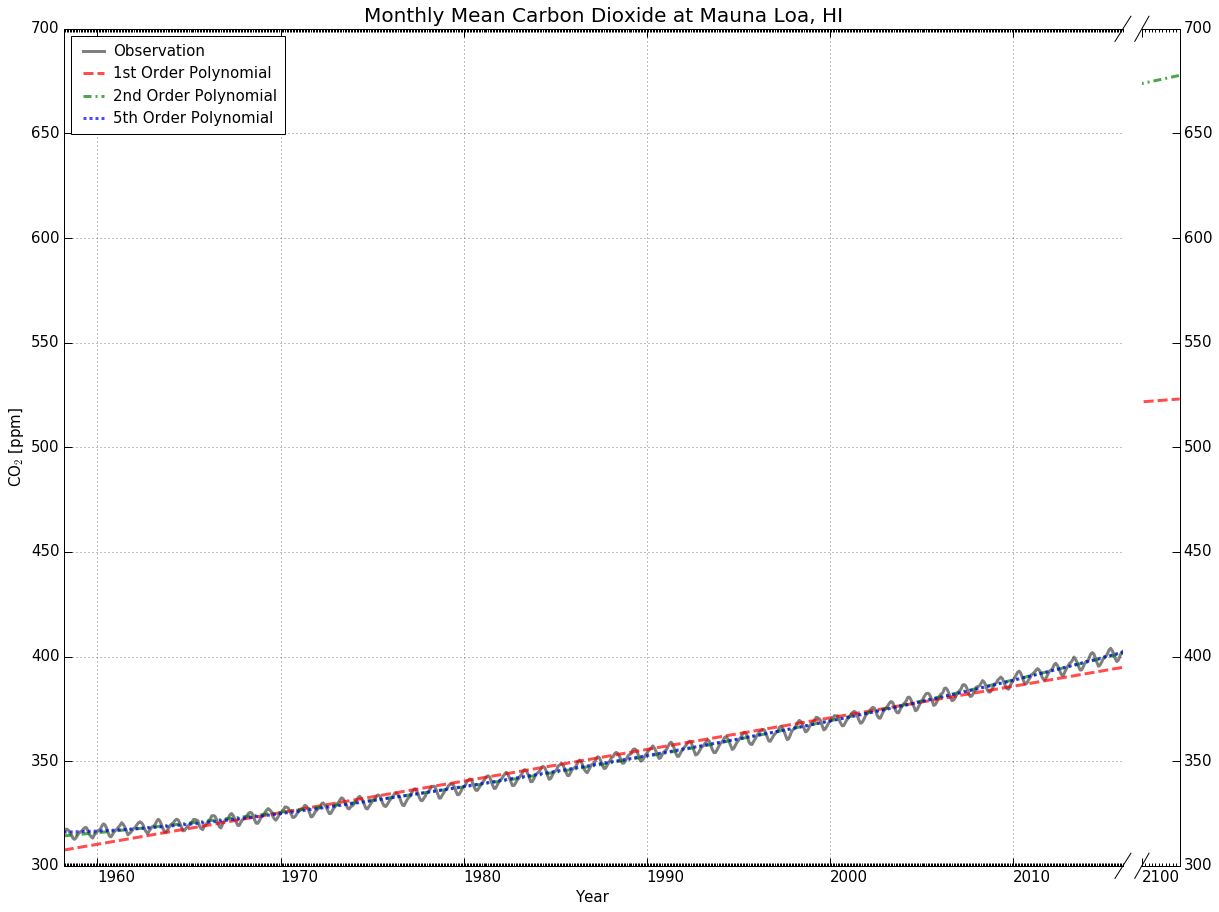

In [17]:
from datetime import date
import matplotlib.gridspec as gridspec
import matplotlib.dates

dates = np.concatenate((np.array([date(int(years[i]), int(months[i]), 1) for i in range(co2.size)]), \
                        np.array([date(2100, i, 1) for i in np.arange(int(months.min()), int(months.max())+1)])))
daten = matplotlib.dates.date2num(dates)

orders = [1, 2, 5]
colors = ['red', 'green', 'blue']
linestyles = [[10, 4], [8, 4, 2, 4], [3, 3]]
labels = ['1st Order Polynomial', '2nd Order Polynomial', '5th Order Polynomial']

pp = []
rmse = np.nan*np.ones(len(orders))
y = np.nan*np.ones((len(orders), daten.size))
for i, order in enumerate(orders):
    pf, rs, _, _, _ = np.polyfit(daten[:co2.size], co2, order, full=True)
    p = np.polynomial.Polynomial(pf[::-1])
    pp.append(p)
    rmse[i] = np.sqrt(np.mean(rs**2))
    y[i] = p(daten)

fig = plt.figure(figsize=(20, 15))

ratio = 20
gs = gridspec.GridSpec(1, ratio)
gs.update(hspace=0, wspace=0.5)
ax1 = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1])
axes = [ax1, ax2]

for ax in axes:
    ax.plot(dates[:co2.size], co2, 'k-', linewidth=3, label='Observation', alpha=0.5)
    for i in range(len(orders)):
        ax.plot(dates, y[i], color=colors[i], linestyle='-', linewidth=3, label=labels[i], alpha=0.7, \
                dashes=linestyles[i])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")
    ax.tick_params('both', length=8, width=1, which='major', labelsize=15)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    ax.tick_params('x', length=3, width=1, which='minor')
    ax.set_xticks(dates, minor=True)
    ax.set_ylim(np.floor(np.array([co2.min(), np.array(y).flat[:co2.size].min()]).min()/50)*50, \
                np.ceil(np.array([co2.max(), np.array(y).flat[:].max()]).max()/50)*50)

ax1.spines['right'].set_visible(False)
ax1.set_xlim(dates[0], dates[co2.size-1])
ax1.set_xlabel('Year', fontsize=15)
ax1.grid(True, color='k', linestyle=':', linewidth=0.5)
ax1.yaxis.tick_left()
ax1.set_ylabel('CO$_{2}$ [ppm]', fontsize=15)

ax2.spines['left'].set_visible(False)
ax2.set_xlim(dates[co2.size], dates[-1])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, end-start))
ax2.yaxis.tick_right()

d = .015
a = d/2
b = a*(ratio+5)
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-a,1+a),(-d,d), **kwargs)
ax1.plot((1-a,1+a),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-b,b),(-d,d), **kwargs)
ax2.plot((-b,b),(1-d,1+d), **kwargs)

ax1.legend(loc='upper left', fontsize=15, handlelength=2, handletextpad=.3, labelspacing=.5, borderpad=.5)
fig.suptitle('Monthly Mean Carbon Dioxide at Mauna Loa, HI', y=0.92, fontsize=20)

plt.show()

In [18]:
print('The polynomial that has the least root-mean-square error is the ', \
      ''.join(np.array(labels)[rmse == min(rmse)]).lower(), '.', sep='')

The polynomial that has the least root-mean-square error is the 5th order polynomial.


However, among the CO$_{2}$ values that this polynomial predicts for 2100, the number of nonzero values is 

In [19]:
print((y[rmse == min(rmse), co2.size:] > 0).sum(), '.', sep='')

0.


In [20]:
print('Then the polynomial that has the second least root-mean-square error is the ', \
       ''.join(np.array(labels)[rmse == np.sort(rmse)[1]]).lower(), '.', sep='')

Then the polynomial that has the second least root-mean-square error is the 2nd order polynomial.


Also the green line in the plot shows that actually this polynomial predicts about 70% increase from 2016 in 2100 presenting nonzero values. Therefore, it seems that the 2nd order polynomial is most accurate.

### 6. (Grad) Make a movie

Make a movie of annual mean surface air temperature predictions from the AR4 model. Data are found in `data/surface_temp_predictions.npz`. Load the data using

    lon, lat, tas = np.load('surface_temp_predictions.npz')['arr_0']

The `['arr_0']` is needed because of the way zipped `npz` files store data; see the docstring for `np.savez`. If that doesn't work (if you get an 'ordinal not in range error), you will need to explicilty specify the encoding:

    lat, lon, sst = np.load('python4geosciences/data/surface_temp_predictions.npz', encoding='latin1')['arr_0']

(The source for the data can be found [here](http://nomads.ncdc.noaa.gov/thredds/dodsC/gfdlcm2x/Stable2000/tas_A1.200101-210012.nc.html)).
Make sure your movie includes some representation of the earth (like coastlines), includes a colorbar, along with other appropriate labels.

The process will be to create a loop that creates a series of frames, labeled `frame_003.png`, for example. You will want to create a string for the filename using some code like this:

    frame_name = 'frame_%03d' % frame_number

Use [ffmpeg](https://www.ffmpeg.org) to stitch the frames together to create an H264 animation that can be played by quicktime. I use a command like this:

    $ ffmpeg -y -r 10 -i frames_%04d.png -c:v libx264 -pix_fmt yuv420p -crf 15 OUTFILE.mp4

where the options mean

    -y                  Overwrite old file
    
    -r 10               Play 10 frames per second
    
    -c:v libx264        Use the H264 library
    
    -crf 15             Use a compression factor of 15 (0=lossless, 51=poor.)
                        Quicktime cannot play lossless encoded movies. 15 appears to be reasonable.

    -pix_fmt yuv420p    Special command so that quicktime can play the movie.  Note, this requires
                        an even number of pixels.  If you don't have this, you can use convert to 
                        crop a pixel off edge of the image.

See [this page]https://trac.ffmpeg.org/wiki/x264EncodingGuide for more information.    

In [29]:
lon, lat, tas = np.load('../data/surface_temp_predictions.npz', encoding='latin1')['arr_0']

tas -= 273.15 # Convert Kelvin to Celsius

In [30]:
from mpl_toolkits.basemap import Basemap
import os # is loaded to create a directory to save figures to if it deos not exist.

m = Basemap(projection='robin', lat_0=0, lon_0=-150, resolution='l')

ln, lt = np.meshgrid(lon, lat)
X, Y = m(ln, lt)
Tmax = abs(tas).max()

filename = 'AMTAS_AR4'
os.system('mkdir -p ' + filename)
dots = 100
for i in np.arange(tas.shape[0]):
    frame_number = i+1
    fig, ax = plt.subplots(figsize=(10, 8), dpi=dots)
    
    mappable = m.pcolormesh(X, Y, tas[i], cmap='RdBu_r', vmin=-Tmax, vmax=Tmax)
    cbar = plt.colorbar(mappable, ax=ax, orientation='horizontal', fraction=.1, pad=.04, aspect=30)
    cbar.ax.text(1.005, 0.5, '[$^\circ$C]', fontsize=15, verticalalignment='center')
    cbar.ax.minorticks_on()
    cbar.ax.tick_params(which='major', width=1, length=8, labelsize=12) 
    cbar.ax.tick_params(which='minor', width=1, length=5, labelsize=12) 

    m.drawcoastlines()
    m.drawmeridians(np.arange(-180, 181, 60), labels=[0, 0, 0, 1], fontsize=12)
    m.drawparallels(np.arange(-90, 91, 30), labels=[0, 1, 0, 0], fontsize=12)

    ax.set_title('Annual Mean Surface Air Temperature Predictions from the AR4 Model', y=1.005, fontsize=15)
    fig.tight_layout()

    fig.savefig(filename + '/' + filename + '_%03d.png' % frame_number, dpi=dots, bbox_inches='tight', pad_inches=0)
    plt.close()

In [31]:
# Make a movie inside Python and delete the directory having the figures
output = filename + '.mp4'

os.chdir(filename)
os.system('ffmpeg -y -r 10 -i ' + filename + '_%03d.png -c:v libx264 -pix_fmt yuv420p -crf 15 ' + output)
os.system('mv ' + output + ' ..')
os.chdir('..')
os.system('rm -rf ' + filename)

0

I tried to embed the movie below. In python 2,

    base64.b64encode(open(file, 'rb').read())
    
can be replaced with the following:

    open(file, 'rb').read().encode('base64')
    
So module `base64` does not need to be loaded, which could be simpler.

In [33]:
from IPython.display import HTML
import base64

def play(file):
    fmt = file.split('.')[-1]
    movie = base64.b64encode(open(file, 'rb').read()).decode('ascii')
    data = '<video controls width="75%" height="75%"><source src="data:video/{0};base64,{1}">\
            </video>'.format(fmt, movie)
    return HTML(data)

play(output)